<font size="5.5"><u><i>Prepare Data</i></u></font>

<font size="4">Script to perform data conditioning for multi-injected strain data: whitening and band-pass filtering</font>
<br/>
<font size="4">Author: Manuel David Morales</font>

## 1. Library imports

In [1]:
# Data analysis
import numpy as np 
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# Files/folders management
import os, glob, sys, re

# To read csv files
import csv

# Scientific computing
from scipy import signal

# Garbage collector
import gc

# Toolbox functions
from Toolbox import PSD, whitening, whitening_PyCBC, filt_bandpass, filt_bandpass_PyCBC, WaveletTF_transform

## 2. Input parameters

In [2]:
# Interferometer for noise data
# ------------------------------------------------------------
detector = "V1"    # Options: "L1", "H1", "V1"
# ------------------------------------------------------------

# Filter's frequency band
# ------------------------------------------------------------
set_band = np.array([100,1800])  # frequency band (in Hz)
# ------------------------------------------------------------

# Remark, about the frequency band:
# This choice is important, in order to capture g-mode, which cover a wide
# region in the frequency domain. It is important to guide our choise in
# the original TF plots for the waveforms before injected to noise.

## 3. Read files

In [3]:
# ------> Specify folder locations

preprocess_dir = '/home/manuel/Research Projects/GW Data analysis/GitHub/CCSNeHFGW_ResNetClass/Codes/Preprocessed_Data'

# ------> Initialize lists

time = []
strain = []
s_files = []

# ------> Scan strain data and waveform files

os.chdir(preprocess_dir)

for file in glob.glob("strain_" + detector + "*injected*"):
    s_files.append(file)

In [4]:
print("Available strain files")
for file in range(len(s_files)):
    print(s_files[file] + "  |  Input option :", file)
print("")

file_i = input("======> Enter your option:")
file_i = int(file_i)
print("")

# ------> Load strain data (this data include injections) 

print("***** READING FILE", s_files[file_i], " *****")
with open(s_files[file_i]) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Data columns: {", ".join(row)}')
            line_count += 1
        else:
            time.append(row[0])
            strain.append(row[1])
            #print(f'\t{row[0]} works in the {row[1]}.')
            line_count += 1
    print(f'Processed {line_count} lines')

# Important remark: Make sure that your option includes the GPS start time
#                   and slope value previously choosen in Make_Injections script

Available strain files
strain_V1_1257050112_injected_wfclass1.txt  |  Input option : 0
strain_V1_1256783872_injected_wfclass1.txt  |  Input option : 1
strain_V1_1256783872_injected_wfclass3.txt  |  Input option : 2
strain_V1_1256783872_injected_wfclass2.txt  |  Input option : 3
strain_V1_1257050112_injected_wfclass2.txt  |  Input option : 4
strain_V1_1257050112_injected_wfclass3.txt  |  Input option : 5



======> Enter your option: 5



***** READING FILE strain_V1_1257050112_injected_wfclass3.txt  *****
Data columns: time, strain
Processed 16777217 lines


In [5]:
# ------> Convert lists to numpy arrays, clear memory from lists

t = np.array(time, dtype='float64')
del(time)
gc.collect()

s_raw = np.array(strain, dtype='float64')
del(strain)
gc.collect()

0

## 4. Whitening preparation

In [6]:
doplot_sraw = 0

# ------> Check: Plot s_raw in the time domain

if doplot_sraw:
    
    plt.figure(1, figsize=(8,5))

    # Comment/uncomment these lines to visualize padding
    #plt.plot(t[:padd+5000], s_raw[:padd+5000], label='s_raw')
    #plt.plot(t[-padd-5000:], s_raw[-padd-5000:], label='s_raw')
    plt.plot(t, s_raw, label='s_raw')

    plt.title("S raw strain data", fontsize=18)
    plt.ylabel("Strain (unitless)", fontsize=13)
    plt.xlabel("time (seconds)", fontsize=13)
    plt.show()
    plt.figure(1).clear()
    gc.collect()

In [7]:
# ------> Count samples in the data segment

Nsamples = len(t)
print("Num of samples in raw strain segment: ", Nsamples)

# ------> Check

if Nsamples % 2 == 1:
    raise ValueError('Nsamples is odd')

# ------> Compute sampling freq and time

fs = 1 / (t[1]-t[0])  # Sampling frequency
ts = 1 / fs           # sampling time

Num of samples in raw strain segment:  16777216


## 5. Whitening application

In [8]:
# ------> Whitening input parameters

doplots_white = 0     # Do plots for check

seg = 4 #0.5                # Welch's segments size (in seconds)
nperseg = int(seg*fs)       # Welch's segments size (in sample units)
nfft = Nsamples             # FFT size (in sample units)

# Only for PyCBC implementation

cut = 10.0 # This is the cut's length (in seconds) to remove edge artifacts
           # in whitened strain data: (cut/2) at left edge, (cut/2) at right edge


In [9]:
# ------> Apply whitening to raw strain data

s_white_t, psd_raw, fpsd_raw, psd_white, fpsd_white = whitening_PyCBC(s_raw, seg, cut, ts, doplots_white)

t_white = s_white_t.sample_times

In [10]:
# ------> Convert PyCBC elements to numpy arrays

t_white = np.array(t_white, dtype='float64')
s_white_t = np.array(s_white_t, dtype='float64')
psd_white = np.array(psd_white, dtype='float64')
fpsd_white = np.array(fpsd_white, dtype='float64')

## 6. Whitening sanity check

In [11]:
doplot_swhite_t = 0
Nsamples_white = len(t_white)

# ------> Check: Plot whitened s_raw

if doplot_swhite_t:
    
    plt.figure(figsize=(8,5))
    plt.plot(t_white, s_white_t, label='s_white')
    plt.title("S whitened data", fontsize=18)
    plt.ylabel("Strain (unitless)", fontsize=13)
    plt.xlabel("time (seconds)", fontsize=13)
    plt.show()
    plt.figure().clear()
    gc.collect()
    print("")
    print("Num of samples in whitened strain segment: ", Nsamples_white)

## 7. Band-pass filtering application

In [12]:
# ------> Input parameters

doplots_bp = 0              # Do plots for check
n_order = 8                 # Filter's order
band = set_band

seg = 4 #0.5                # Welch's segments size (in seconds)
nperseg = int(seg*fs)       # Welch's segments size (in sample units)

In [13]:
# ------> Apply band-pass filtering to whitened strain data

s_filt_t, psd_filt, fpsd_filt = filt_bandpass_PyCBC(s_white_t, n_order, band, ts, seg, doplots_bp)

t_filt = s_filt_t.sample_times

In [14]:
# ------> Convert PyCBC elements to numpy arrays

t_filt = np.array(t_filt, dtype='float64')
s_filt_t = np.array(s_filt_t, dtype='float64')
psd_filt = np.array(psd_filt, dtype='float64')
fpsd_filt = np.array(fpsd_filt, dtype='float64')

# ------> Displace time of filtered strain data

t_filt = t_filt + t_white[0]

## 8. Band-pass filtering sanity check

In [15]:
# ------> Check: Plot spectrogram

# Remark: Run this check for a short data segment with a few injections

doplot_spectrogram = 0

wnd="hamming" # Window for spectrograms

if doplot_spectrogram:
    
    freq, time, Sxx = signal.spectrogram(s_filt_t, fs, window=wnd, nperseg=1024)
    #time, freq, WL = WaveletTF_transform(s_filt_t, fs, 1, 2000, 5, 7, 0)
    
    plt.figure(1,figsize=(6.5,5))
    plt.pcolormesh(time+t_filt[0], freq, Sxx, shading='gouraud')
    plt.ylabel('Frequency [Hz]', fontsize=14)
    plt.xlabel('Time [sec]', fontsize=14)
    plt.show()
    plt.figure(2).clear()
    gc.collect(1)
    
    #plt.figure(2, figsize=(6.7,5))
    #plt.plot(t, s_filt_t, label='s_filt')
    #plt.title("S whitened and filtered data", fontsize=18)
    #plt.ylabel("Strain (unitless)", fontsize=13)
    #plt.xlabel("time (seconds)", fontsize=13)
    #plt.show()
    #plt.figure(2).clear()
    #gc.collect()

## 9. General sanity checks

### 9.1. Strain data: Raw, White, Whit+Filt

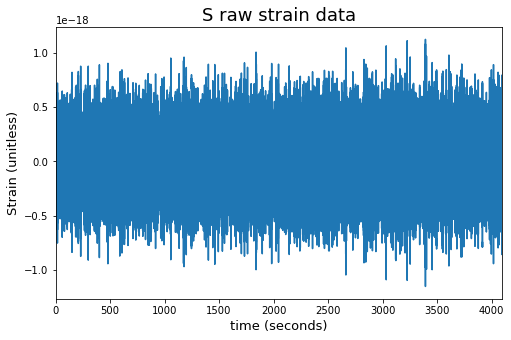

<Figure size 432x288 with 0 Axes>

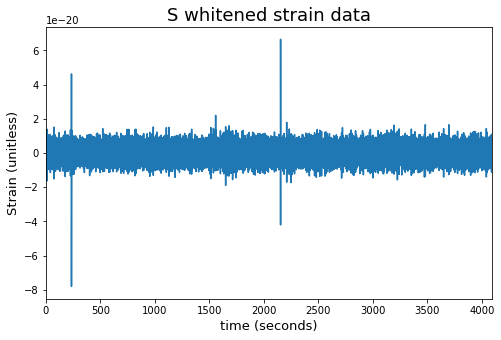

<Figure size 432x288 with 0 Axes>

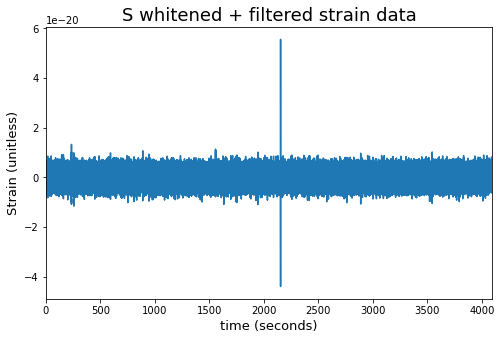

<Figure size 432x288 with 0 Axes>

In [16]:
doplot_strains = 1

# ------> Check: Plot raw/whitened/filtered strain data

if doplot_strains:
    
        
    t_min = np.min(t); t_max = np.max(t)
    
    plt.figure(1, figsize=(8,5))
    plt.plot(t, s_raw)
    plt.title("S raw strain data", fontsize=18)
    plt.ylabel("Strain (unitless)", fontsize=13)
    plt.xlabel("time (seconds)", fontsize=13)
    plt.xlim(left=t_min, right=t_max)
    plt.show()
    plt.figure(1).clear()
    gc.collect()

    plt.figure(2, figsize=(8,5))
    plt.plot(t_white, s_white_t)
    plt.title("S whitened strain data", fontsize=18)
    plt.ylabel("Strain (unitless)", fontsize=13)
    plt.xlabel("time (seconds)", fontsize=13)
    plt.xlim(left=t_min, right=t_max)
    plt.show()
    plt.figure(2).clear()
    gc.collect()

    plt.figure(3, figsize=(8,5))
    plt.plot(t_filt, s_filt_t)
    plt.title("S whitened + filtered strain data", fontsize=18)
    plt.ylabel("Strain (unitless)", fontsize=13)
    plt.xlabel("time (seconds)", fontsize=13)
    plt.xlim(left=t_min, right=t_max)
    plt.show()
    plt.figure(3).clear()
    gc.collect()

### 9.1. Spectrogram: White+Filt

In [17]:
# ------> Check: Plot spectrogram

# Remark: This visual check is useful for a noise segment with
#         a few injections (2, 3,.., no more 5)

doplot_spectrogram = 0

wnd="hamming" # Window for spectrograms

if doplot_spectrogram:
    
    plt.figure(1, figsize=(6.7,5))
    plt.plot(t_filt, s_filt_t, label='s_raw')

    plt.title("S whitened + filtered strain data", fontsize=18)
    plt.ylabel("Strain (unitless)", fontsize=13)
    plt.xlabel("time (seconds)", fontsize=13)
    plt.show()
    plt.figure(1).clear()
    gc.collect()
    
    freq, time, Sxx = signal.spectrogram(s_filt_t, fs, window=wnd, nperseg=512)
    
    plt.figure(2,figsize=(6.5,5))
    plt.pcolormesh(time+t_filt[0], freq, Sxx, shading='gouraud')
    plt.ylabel('Frequency [Hz]', fontsize=14)
    plt.xlabel('Time [sec]', fontsize=14)
    plt.show()
    plt.figure(2).clear()
    gc.collect()

### 9.2. Amplitude Spectral Density (ASD)

In [18]:
# ------> Compute ASD quantities

# Raw strain data ASD
# ---------------------

asd_raw = np.sqrt(psd_raw)

# Whitened strain data ASD
# --------------------------

asd_white = np.sqrt(psd_white)

# Filtered strain data ASD
# --------------------------

asd_filt = np.sqrt(psd_filt)


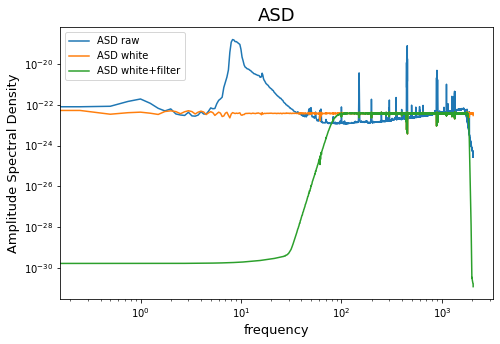

12602

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot ADS for raw/whitened/filtered strain data

#mpl.rcParams['agg.path.chunksize'] = 10000

plt.figure(figsize=(7.75,5))
plt.plot(fpsd_raw, asd_raw, label='ASD raw')
plt.plot(fpsd_white, asd_white, label='ASD white')
plt.plot(fpsd_filt, asd_filt, label='ASD white+filter')
#plt.xlim(left=9)
plt.xscale('log')
plt.yscale('log')
plt.title("ASD", fontsize=18)
plt.ylabel("Amplitude Spectral Density", fontsize=13)
plt.xlabel("frequency", fontsize=13)
plt.legend()
plt.show()
plt.figure().clear()
gc.collect()

## 10. Save data

In [20]:
# ------> Extract gps time and waveform duration from read filename

r = re.search("_inj", s_files[file_i])
i_end = r.span()[0]
r = re.search(detector + "_", s_files[file_i])
i_ini = r.span()[0]

gps = s_files[file_i][i_ini+3:i_end]

# ------> Extract waveform class from read file

waveform_class = s_files[file_i][-5:-4]

# ------> Save conditioned strain data

# Pre-processed data folder
save_dir = '/home/manuel/Research Projects/GW Data analysis/GitHub/CCSNeHFGW_ResNetClass/Codes/Preprocessed_Data/'

# Create df_strain dataset
df_strain = pd.DataFrame({"time" : t_filt, "strain" : s_filt_t})

# Export df_strain dataframe to a csv file
df_strain.to_csv("strain_" + detector + "_" + gps + "_conditioned_" + "wfclass" + waveform_class + ".txt", index=False)